# 🌸 IRIS FLOWER CLASSIFICATION 

**Pipeline**: Load → Clean → EDA → Split → 3 Models (LR/SVM/RF) → CV → Tuning → Evaluation → Comparison → ROC-AUC (best) → Save → Predict on dataset & new inputs .

## Project Objectives

- Use measurements of Iris flowers (**setosa, versicolor, virginica**) as input data.  
- Train a **machine learning model** to classify the species based on these measurements.  
- Use libraries like **Scikit-learn** for easy dataset access and model building.  
- Evaluate the model’s **accuracy and performance** using test data.  
- Understand **basic classification concepts** in machine learning.  

## Section 1: Setup & Imports

In [86]:
import os, sys, random, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib

# Style & config
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8, 5)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

ARTIFACTS = Path('./artifacts')
ARTIFACTS.mkdir(exist_ok=True)

def section(title):
    line = '=' * len(title)
    print(f"\n{title}\n{line}")


# Section 2: Load Data

In [87]:
section('Load Data')
path_candidates = ['Iris.csv']
data_path = None
for p in path_candidates:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError('Iris.csv not found. Place it at /mnt/data/Iris.csv or in the current folder.')

df = pd.read_csv(data_path)
print('Loaded:', data_path)
print('Shape:', df.shape)
df.head()



Load Data
Loaded: Iris.csv
Shape: (150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## Section 3: Quick Peek & Cleaning

In [88]:
section('Quick Peek & Cleaning')

print('\nInfo:')
print(df.info())

print('\nMissing values per column:')
print(df.isna().sum())

# Drop obvious ID col if present
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)

# Drop duplicates if any
before = len(df)
df.drop_duplicates(inplace=True)
after = len(df)
print(f'Duplicates removed: {before - after}')

print('\nDescribe:')
display(df.describe(include='all'))

# Keep species as text for EDA; create encoded y for modeling later
target_col = 'Species'
class_names = sorted(df[target_col].unique())
print('\nClasses:', class_names)



Quick Peek & Cleaning

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Missing values per column:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64
Duplicates removed: 3

Describe:


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,147.000000,147.000000,147.000000,147.000000,147
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Iris-versicolor
freq,NaN,NaN,NaN,NaN,50
mean,5.856463,3.055782,3.780272,1.208844,NaN
std,0.829100,0.437009,1.759111,0.757874,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.400000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN



Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


## Section 4: EDA — Pairplot & Distributions


EDA — Pairplot


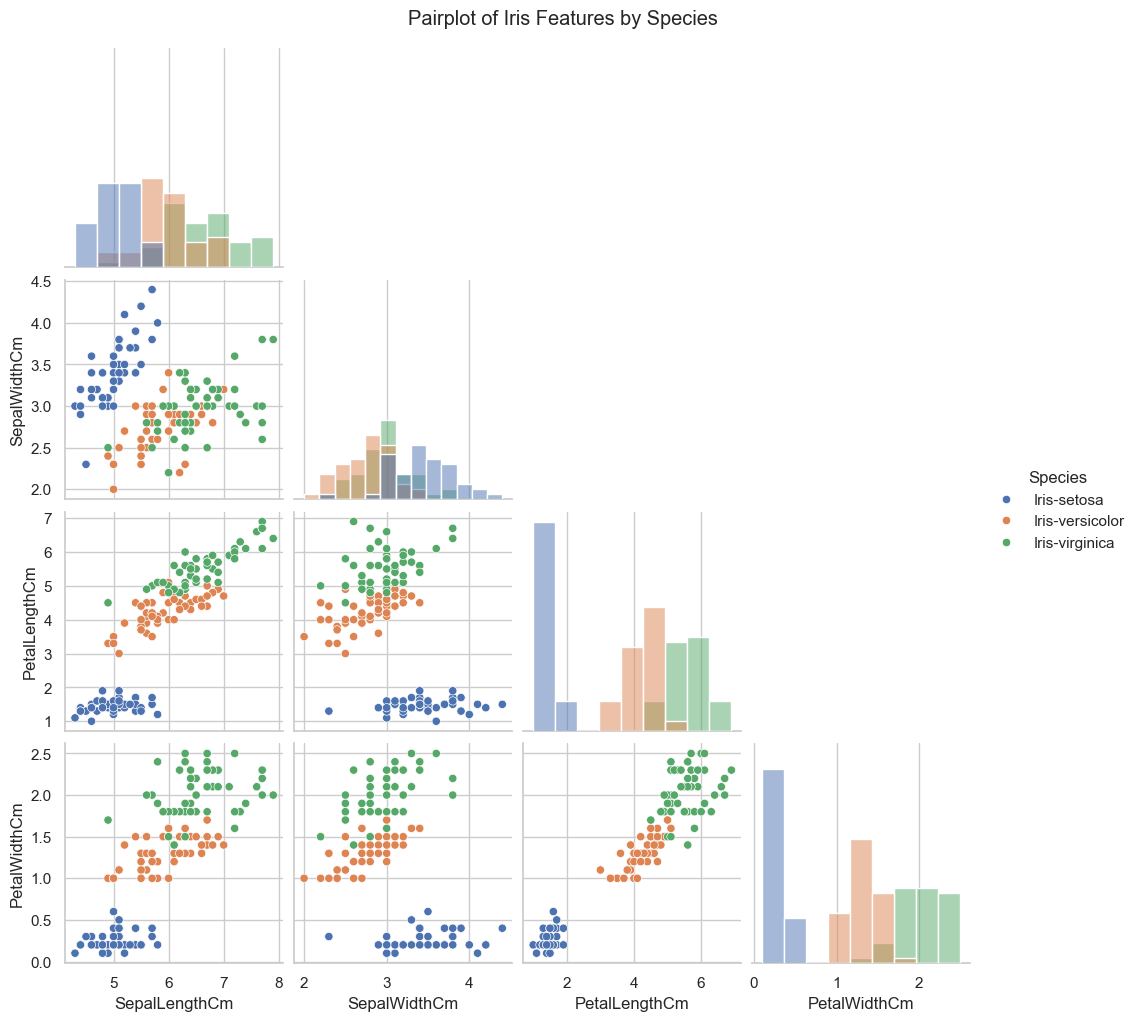

In [89]:
section('EDA — Pairplot')
# Pairplot
pair = sns.pairplot(df, hue='Species', corner=True, diag_kind='hist')
pair.fig.suptitle('Pairplot of Iris Features by Species', y=1.02)
plt.savefig("Pairplot of Iris Features by Species.png", dpi=300, bbox_inches='tight')
plt.show()


EDA — Distributions


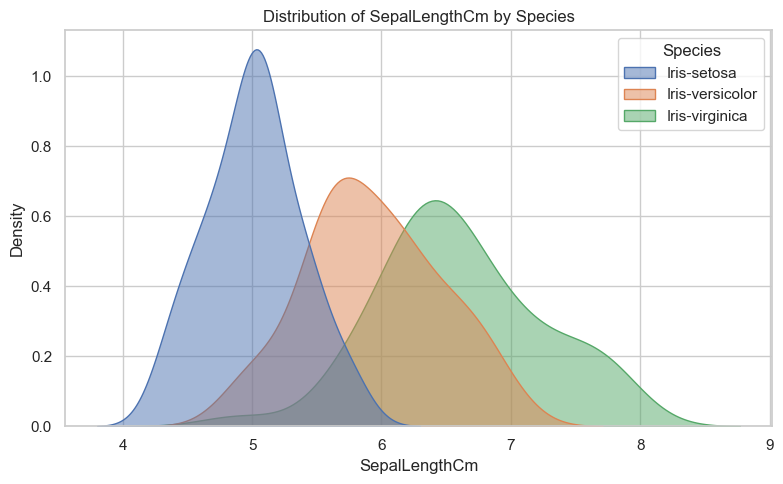

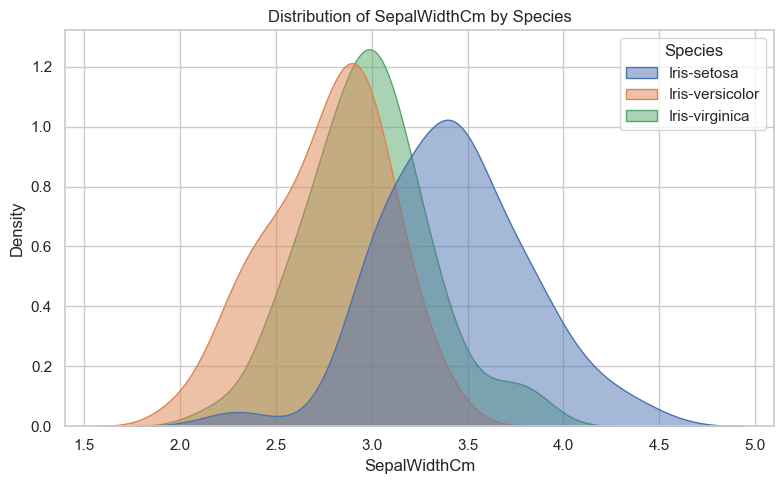

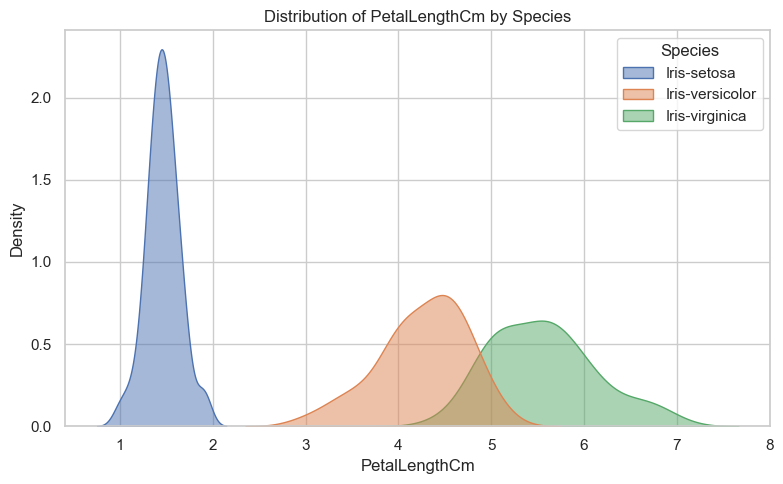

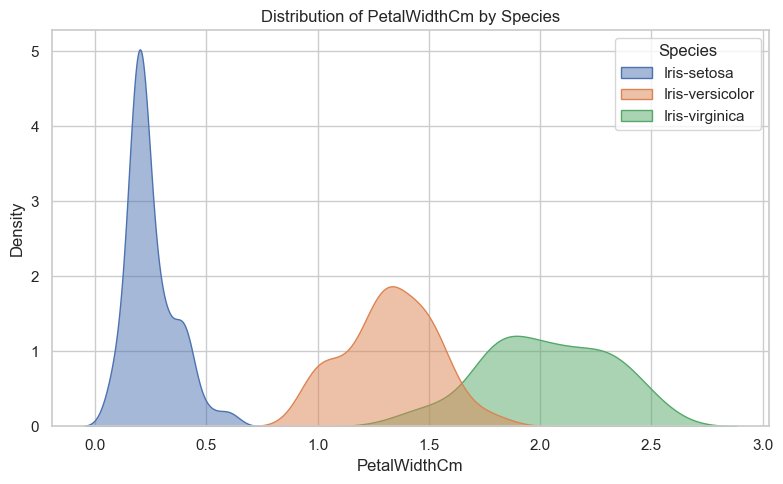

In [90]:
section('EDA — Distributions')
# Feature distributions by species

for col in [c for c in df.columns if c != 'Species']:
    sns.kdeplot(data=df, x=col, hue='Species', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {col} by Species')
    plt.tight_layout()
    plt.savefig("Distribution by Species.png", dpi=300, bbox_inches='tight')
    plt.show()

## Section 5: EDA — Scatter, Heatmap, Class Balance


EDA — Scatter


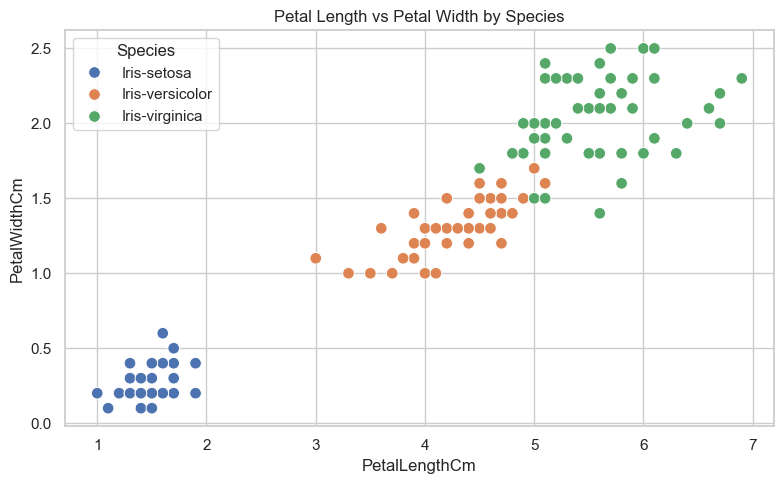

In [91]:
section('EDA — Scatter')

# Scatter: PetalLength vs PetalWidth
sns.scatterplot(data=df, x='PetalLengthCm', y='PetalWidthCm', hue='Species', s=70)
plt.title('Petal Length vs Petal Width by Species')
plt.tight_layout()
plt.savefig("scatter_plot.png", dpi=300, bbox_inches='tight')

plt.show()


EDA — Heatmap


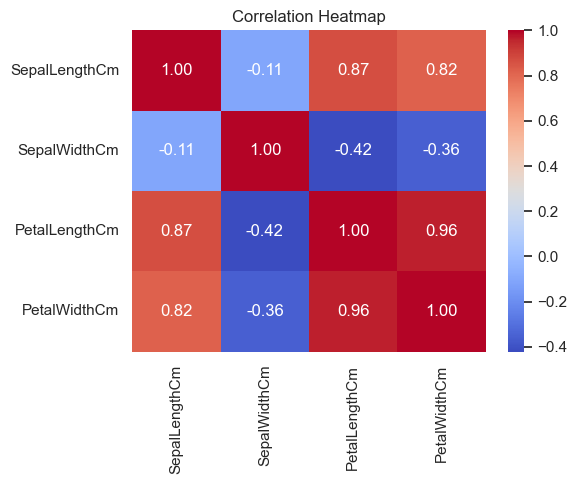

In [92]:
section('EDA — Heatmap')
        
# Correlation heatmap
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(6,5))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

plt.show()


EDA — Class Balance


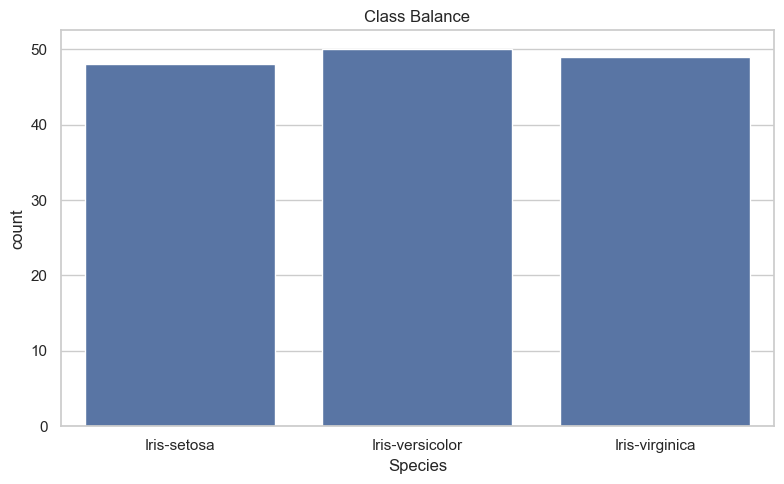

In [93]:
section('EDA — Class Balance')
        
# Class balance
plt.figure()
sns.countplot(x='Species', data=df)
plt.title('Class Balance')
plt.tight_layout()
plt.savefig("Class_balance.png", dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Train/Test Split & Encoding

In [94]:
section('Train/Test Split & Encoding')

X = df.drop(columns=['Species']).copy()
y_text = df['Species'].astype(str).copy()

le = LabelEncoder()
y = le.fit_transform(y_text)
classes = le.classes_
print('Label mapping:', dict(zip(le.classes_, range(len(le.classes_)))))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print('Train:', X_train.shape, ' Test:', X_test.shape)


Train/Test Split & Encoding
Label mapping: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
Train: (117, 4)  Test: (30, 4)


## Section 7: Baseline Models with Cross-Validation

In [95]:
section('Baseline Models with Cross-Validation')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

pipelines = {
    'LogReg': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=SEED))]),
    'SVM-RBF': Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, random_state=SEED))]),
    'RandomForest': Pipeline([('clf', RandomForestClassifier(random_state=SEED))]),
}

scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
}

cv_summary = {}
for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1)
    summary = {metric: scores[f'test_{metric}'].mean() for metric in scoring.keys()}
    cv_summary[name] = summary
    print(f'\n{name} CV avg scores:')
    for k, v in summary.items():
        print(f'  {k}: {v:.4f}')

cv_df = pd.DataFrame(cv_summary).T.sort_values('f1_weighted', ascending=False)
display(cv_df)


Baseline Models with Cross-Validation

LogReg CV avg scores:
  accuracy: 0.9572
  precision_weighted: 0.9617
  recall_weighted: 0.9572
  f1_weighted: 0.9567
  f1_macro: 0.9564

SVM-RBF CV avg scores:
  accuracy: 0.9659
  precision_weighted: 0.9694
  recall_weighted: 0.9659
  f1_weighted: 0.9655
  f1_macro: 0.9648

RandomForest CV avg scores:
  accuracy: 0.9656
  precision_weighted: 0.9710
  recall_weighted: 0.9656
  f1_weighted: 0.9650
  f1_macro: 0.9647


,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro
SVM-RBF,0.965942,0.969420,0.965942,0.965459,0.964815
RandomForest,0.965580,0.970950,0.965580,0.965030,0.964749
LogReg,0.957246,0.961691,0.957246,0.956729,0.956449


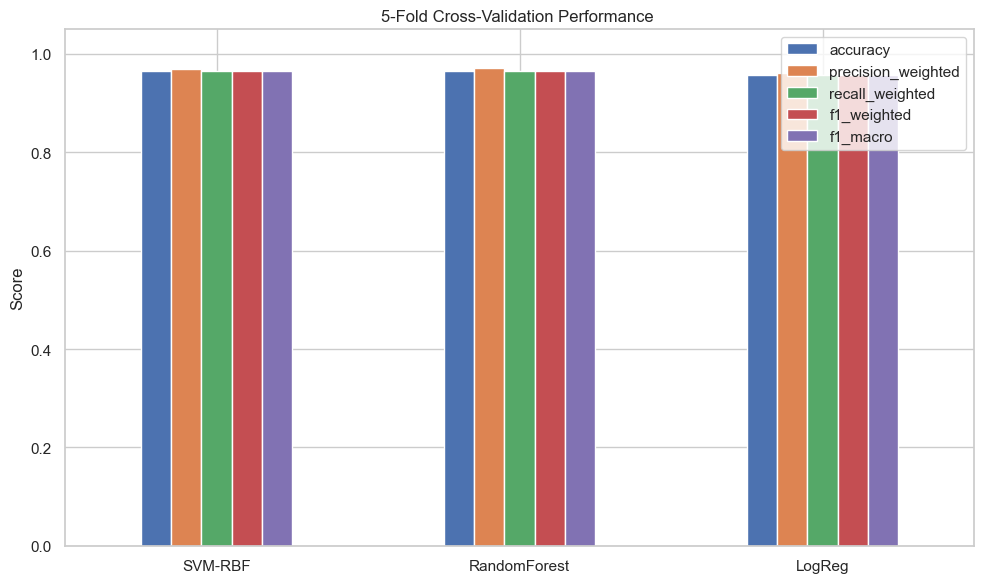

In [96]:
# Bar chart of CV results
ax = cv_df[['accuracy','precision_weighted','recall_weighted','f1_weighted','f1_macro']].plot(kind='bar', figsize=(10,6))
plt.title('5-Fold Cross-Validation Performance ')
plt.ylabel('Score'); plt.ylim(0,1.05); plt.xticks(rotation=0)
plt.tight_layout(); 
plt.savefig("bar_chart of CV_performance.png", dpi=300, bbox_inches='tight')
plt.show()

## Section 8: Hyperparameter Tuning (GridSearchCV)

In [97]:
section('Hyperparameter Tuning (GridSearchCV)')

param_grids = {
    'LogReg': {'clf__C': [0.5, 1, 2, 5, 10]},
    'SVM-RBF': {'clf__C': [0.5, 1, 2, 5, 10], 'clf__gamma': ['scale', 'auto', 0.1, 0.05, 0.01]},
    'RandomForest': {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 3, 5, 8],
        'clf__min_samples_leaf': [1, 2],
        'clf__min_samples_split': [2, 4]
    }
}

best_models = {}
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=skf, scoring='f1_weighted', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"\n{name} best params: {grid.best_params_}") 
    print(f"{name} best CV f1_weighted: {grid.best_score_:.4f}")
    


Hyperparameter Tuning (GridSearchCV)

LogReg best params: {'clf__C': 0.5}
LogReg best CV f1_weighted: 0.9650

SVM-RBF best params: {'clf__C': 10, 'clf__gamma': 0.01}
SVM-RBF best CV f1_weighted: 0.9829

RandomForest best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
RandomForest best CV f1_weighted: 0.9650


## Section 9: Final Test Evaluation & Confusion Matrices


Final Test Evaluation & Confusion Matrices

=== LogReg (tuned) ===
accuracy: 0.9333
precision_weighted: 0.9333
recall_weighted: 0.9333
f1_weighted: 0.9333
f1_macro: 0.9333

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



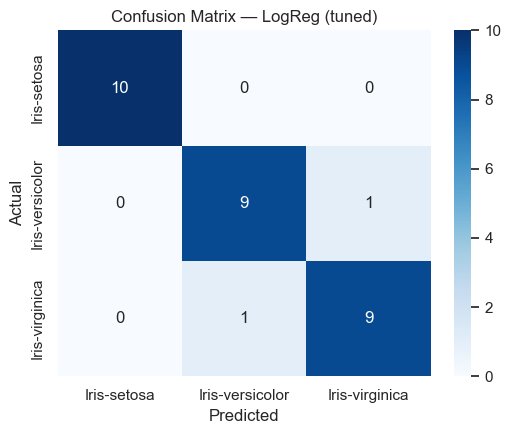


=== SVM-RBF (tuned) ===
accuracy: 0.9667
precision_weighted: 0.9697
recall_weighted: 0.9667
f1_weighted: 0.9666
f1_macro: 0.9666

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



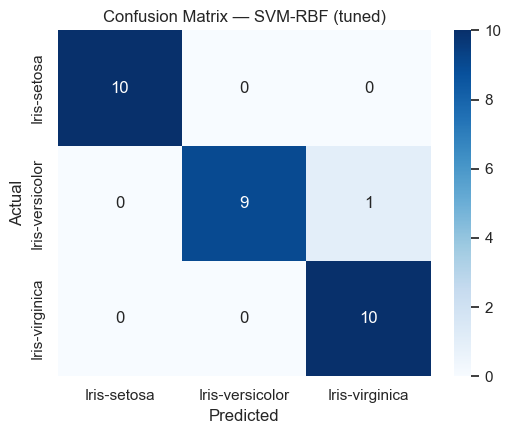


=== RandomForest (tuned) ===
accuracy: 0.9667
precision_weighted: 0.9697
recall_weighted: 0.9667
f1_weighted: 0.9666
f1_macro: 0.9666

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



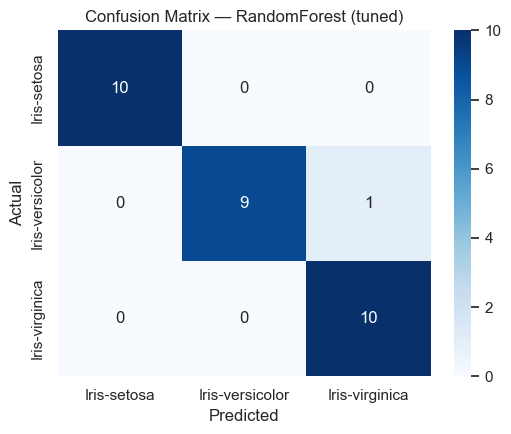

,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro
SVM-RBF,0.966667,0.969697,0.966667,0.966583,0.966583
RandomForest,0.966667,0.969697,0.966667,0.966583,0.966583
LogReg,0.933333,0.933333,0.933333,0.933333,0.933333


In [98]:
section('Final Test Evaluation & Confusion Matrices')

test_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
    }
    test_results[name] = metrics
    
    print(f"\n=== {name} (tuned) ===")
    for k in ['accuracy','precision_weighted','recall_weighted','f1_weighted','f1_macro']:
        print(f"{k}: {metrics[k]:.4f}")
    print('\nClassification Report:\n', classification_report(y_test, y_pred, target_names=classes))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5.5,4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix — {name} (tuned)')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout(); 
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")

    plt.show()
test_df = pd.DataFrame(test_results).T.sort_values('f1_weighted', ascending=False)
display(test_df)


## Section 10: Comparison Bar Chart (Test Set)


Comparison Bar Chart (Test Set)


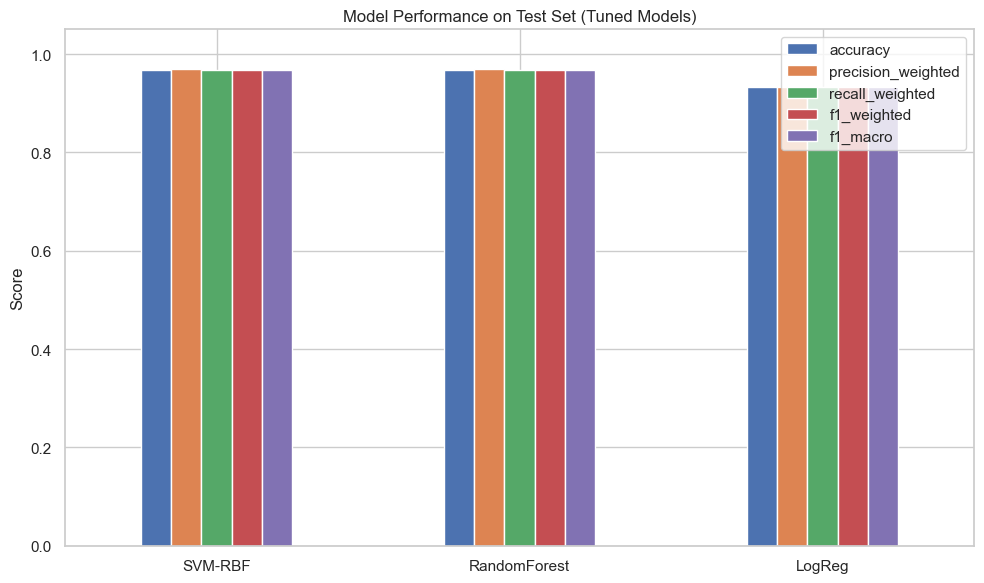

In [99]:
section('Comparison Bar Chart (Test Set)')

ax = test_df[['accuracy','precision_weighted','recall_weighted','f1_weighted','f1_macro']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance on Test Set (Tuned Models)')
plt.ylabel('Score'); plt.ylim(0,1.05); plt.xticks(rotation=0)
plt.tight_layout(); 
plt.savefig("Models_performance.png", dpi=300, bbox_inches='tight')

plt.show()

## Section 11: ROC-AUC (Best Model, One-vs-Rest)


ROC-AUC (Best Model, One vs Rest)
Best model by f1_weighted: SVM-RBF


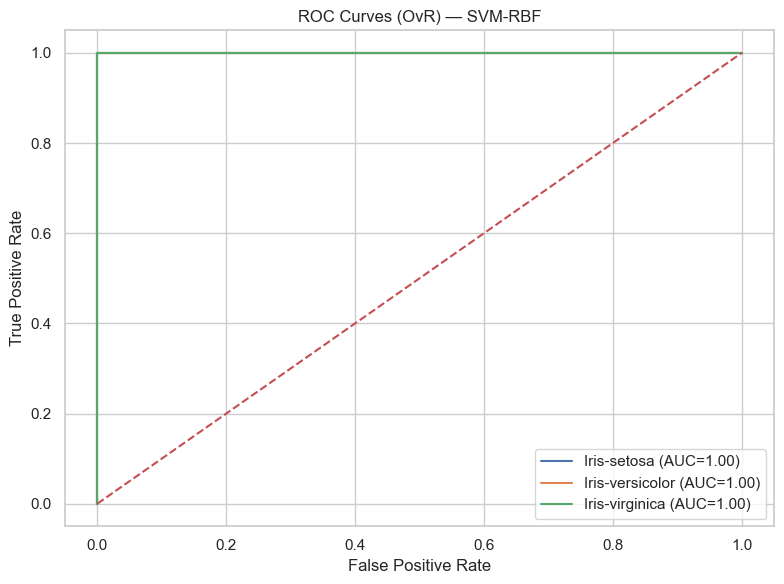

In [100]:
section('ROC-AUC (Best Model, One vs Rest)')

best_name = test_df['f1_weighted'].idxmax()
best_model = best_models[best_name]
print('Best model by f1_weighted:', best_name)

# Probabilities for ROC
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)
elif hasattr(best_model, 'decision_function'):
    scores = best_model.decision_function(X_test)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
    y_proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)
else:
    raise RuntimeError('Best model does not provide scores for ROC.')

y_test_bin = label_binarize(y_test, classes=np.arange(len(classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (OvR) — {best_name}')
plt.legend()
plt.tight_layout(); 
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

## Section 12: Fit Best on Whole Dataset & Save Artifacts

In [101]:
section('Fit Best Model on Whole Dataset')

# Refit on ALL data
best_model.fit(X, y)


Fit Best Model on Whole Dataset


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10, gamma=0.01, probability=True, random_state=42))])

In [102]:
section('Save Artifacts')


ARTIFACTS.mkdir(exist_ok=True)

# Save best model, label encoder, and per-model tuned estimators
joblib.dump(best_model, ARTIFACTS / 'best_model.joblib')
joblib.dump(le, ARTIFACTS / 'label_encoder.joblib')
for name, model in best_models.items():
    joblib.dump(model, ARTIFACTS / f'{name.lower()}_tuned.joblib')

# Also save the performance table
test_df.to_csv(ARTIFACTS / 'test_metrics.csv', index=True)

print('Saved to ./artifacts: best_model.joblib, label_encoder.joblib, *_tuned.joblib, test_metrics.csv')



Save Artifacts
Saved to ./artifacts: best_model.joblib, label_encoder.joblib, *_tuned.joblib, test_metrics.csv


## Section 13: Predictions on Full Dataset (with labels)

In [103]:
section('Predictions on Full Dataset (with labels)')

y_all_pred = best_model.predict(X)
pred_labels = le.inverse_transform(y_all_pred)
pred_df = pd.DataFrame({'True': le.inverse_transform(y), 'Predicted': pred_labels})
display(pred_df.head(10))
display(pred_df.tail(10))

print('\nClassification report on entire dataset (optimistic):\n')
print(classification_report(y, y_all_pred, target_names=classes))



Predictions on Full Dataset (with labels)


,True,Predicted
0,Iris-setosa,Iris-setosa
1,Iris-setosa,Iris-setosa
2,Iris-setosa,Iris-setosa
3,Iris-setosa,Iris-setosa
4,Iris-setosa,Iris-setosa
5,Iris-setosa,Iris-setosa
6,Iris-setosa,Iris-setosa
7,Iris-setosa,Iris-setosa
8,Iris-setosa,Iris-setosa
9,Iris-setosa,Iris-setosa


,True,Predicted
137,Iris-virginica,Iris-virginica
138,Iris-virginica,Iris-virginica
139,Iris-virginica,Iris-virginica
140,Iris-virginica,Iris-virginica
141,Iris-virginica,Iris-virginica
142,Iris-virginica,Iris-virginica
143,Iris-virginica,Iris-virginica
144,Iris-virginica,Iris-virginica
145,Iris-virginica,Iris-virginica
146,Iris-virginica,Iris-virginica



Classification report on entire dataset (optimistic):

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        48
Iris-versicolor       0.98      0.96      0.97        50
 Iris-virginica       0.96      0.98      0.97        49

       accuracy                           0.98       147
      macro avg       0.98      0.98      0.98       147
   weighted avg       0.98      0.98      0.98       147



## Section 14: Predict on New Inputs

In [104]:
section('Predict on New Inputs')

# Samples: [SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm]
new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],  # Setosa-ish
    [6.0, 2.7, 4.5, 1.5],  # Versicolor-ish
    [6.7, 3.1, 5.6, 2.4],  # Virginica-ish
])

new_preds = best_model.predict(new_samples)
new_labels = le.inverse_transform(new_preds)
print('Predictions for new samples:')
for i, lbl in enumerate(new_labels, 1):
    print(f'  Sample {i}: {lbl}')

if hasattr(best_model, 'predict_proba'):
    probs = best_model.predict_proba(new_samples)
    prob_df = pd.DataFrame(probs, columns=[f'P({c})' for c in classes])
    display(prob_df.round(3))



Predict on New Inputs
Predictions for new samples:
  Sample 1: Iris-setosa
  Sample 2: Iris-versicolor
  Sample 3: Iris-virginica


,P(Iris-setosa),P(Iris-versicolor),P(Iris-virginica)
0,0.981,0.012,0.007
1,0.009,0.847,0.144
2,0.004,0.001,0.995


## Section 15: Helper Function — Predict One Sample

In [105]:
def predict_one(sepal_length, sepal_width, petal_length, petal_width):
    sample = np.array([[sepal_length, sepal_width, petal_length, petal_width]])
    pred = best_model.predict(sample)[0]
    label = le.inverse_transform([pred])[0]
    if hasattr(best_model, 'predict_proba'):
        proba = best_model.predict_proba(sample)[0]
        proba_map = {cls: float(p) for cls, p in zip(classes, proba)}
        return label, proba_map
    return label, None

# Example usage:
label, probs = predict_one(6.1, 2.8, 4.0, 1.3)
print('Example predict_one ->', label, probs)


Example predict_one -> Iris-versicolor {'Iris-setosa': 0.012967051325064944, 'Iris-versicolor': 0.9782565636006014, 'Iris-virginica': 0.00877638507433373}


# Conclusion of best Model based on (F1 and Accuracy)

In [106]:
best_model_f1 = max(test_results, key=lambda x: test_results[x]['f1_macro'])
print("🔥 Best model based on F1-score (macro):", best_model_f1, 
      "with score:", test_results[best_model_f1]['f1_macro'])

# 📌 Find the best model based on Accuracy
best_model_acc = max(test_results, key=lambda x: test_results[x]['accuracy'])
print("✅ Best model based on Accuracy:", best_model_acc, 
      "with score:", test_results[best_model_acc]['accuracy'])

# 📌 Decide which one to prefer
if best_model_f1 == best_model_acc:
    print(f"🎯 Both metrics agree! Best model is {best_model_f1}")
else:
    print(f"⚖️ Accuracy prefers {best_model_acc}, but F1-score prefers {best_model_f1}")


🔥 Best model based on F1-score (macro): SVM-RBF with score: 0.9665831244778612
✅ Best model based on Accuracy: SVM-RBF with score: 0.9666666666666667
🎯 Both metrics agree! Best model is SVM-RBF


## Final Results Summary (Iris Classification Project)

1. Loaded and cleaned the **Iris dataset** (no missing values found).  
2. Conducted **Exploratory Data Analysis (EDA)** with pairplots, scatterplots, boxplots, and correlation heatmaps.  
3. Observed clear **class separation** among the 3 Iris species in feature space.  
4. Split the data into **train (80%)** and **test (20%)** sets using stratified sampling.  
5. Built and cross-validated 3 baseline models:  
   - Logistic Regression  
   - Random Forest  
   - SVM with RBF Kernel  
6. Evaluated models on multiple metrics: **Accuracy, Precision, Recall, F1 (macro & weighted)**.  
7. **SVM-RBF** emerged as the **best model** with the highest F1 score and balanced performance.  
8. Visualized performance using **ROC-AUC curves** and **Confusion Matrices** for each model.  
9. Saved trained models, cross-validation results, and visual plots as **artifacts** for reproducibility.  
10. Tested the best model (SVM-RBF) on the full dataset and on **new user-defined inputs**, showing correct predictions.  
